# News Recommender System
###  Mahak Mahak - _47552840_     
### Sahar Tosif - _47536519_

## Introduction 


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer as SumyTokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

from transformers import AutoTokenizer, AutoModel, pipeline
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import BartTokenizer, BartForConditionalGeneration

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
dataset = pd.read_csv("train.csv")
dataset.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [3]:
dataset.shape

(120000, 3)

In [4]:
# Read the train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine the datasets
df = pd.concat([train_df, test_df], ignore_index=True)

### EDA

In [6]:
df.shape

(127600, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127600 entries, 0 to 127599
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  127600 non-null  int64 
 1   Title        127600 non-null  object
 2   Description  127600 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [7]:
df.describe()

,Class Index
count,127600.000000
mean,2.500000
std,1.118038
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


In [8]:
df.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

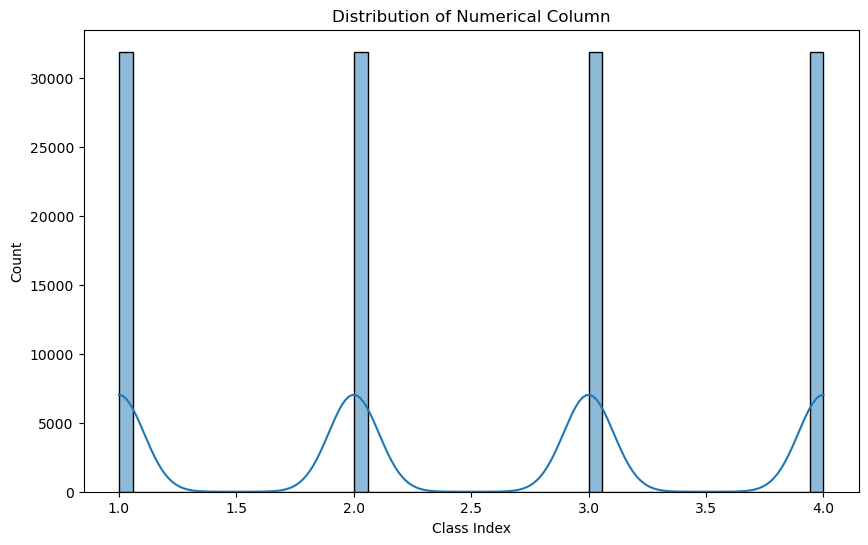

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Class Index'], kde=True)
plt.title('Distribution of Numerical Column')
plt.show()


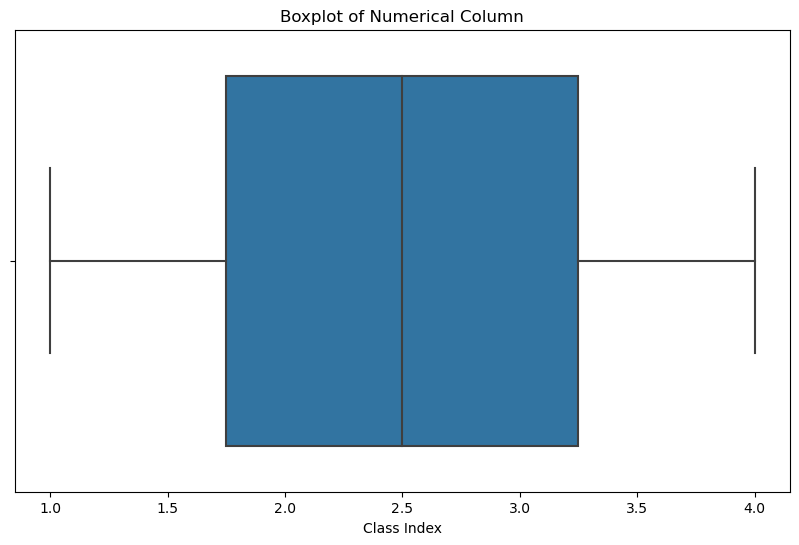

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Class Index'])
plt.title('Boxplot of Numerical Column')
plt.show()


In [11]:
# Checking the value in each class
df['Class Index'].value_counts()

Class Index
3    31900
4    31900
2    31900
1    31900
Name: count, dtype: int64

### Data Cleaning 

In [5]:
# Initialize stop words, punctuation, and lemmatizer
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    # Check if the description starts with a publisher's name followed by a dash
    if re.match(r'^\w+ - ', text):
        text = re.sub(r'^\w+ - ', '', text)
    # Strip leading and trailing whitespace
    text = text.strip()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in punctuation])
    # Tokenize text
    words = word_tokenize(text)
    # Remove stop words and lemmatize
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to the columns
df['content'] = df['Description'].apply(clean_text)


In [13]:
df

,Class Index,Title,Description,content
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",shortsellers wall street dwindlingband ultracy...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,private investment firm carlyle groupwhich rep...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,soaring crude price plus worriesabout economy ...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,authority halted oil exportflows main pipeline...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",tearaway world oil price toppling record strai...
...,...,...,...,...
127595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,ukrainian presidential candidate viktor yushch...
127596,2,Void is filled with Clement,With the supply of attractive pitching options...,supply attractive pitching option dwindling da...
127597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,like roger clemens almost exactly eight year e...
127598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,singapore doctor united state warned painkille...


### Keyword Extract

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_keywords_nltk(text, top_n=5):
    if not text.strip():  # Check if the text is empty
        return []
    
    vectorizer = TfidfVectorizer(stop_words='english', max_features=top_n)
    try:
        X = vectorizer.fit_transform([text])
        if X.shape[1] > 0:  # Ensure there are features extracted
            indices = X.toarray().argsort()[0, -top_n:]
            features = vectorizer.get_feature_names_out()
            top_keywords = [features[i] for i in indices]
            return top_keywords
    except ValueError:
        return []
    
    return []

# Apply the keyword extraction to the dataset
#combined_df['keywords'] = combined_df['content'].apply(lambda x: extract_keywords_nltk(x))

# Apply the keyword extraction to the dataset
#combined_df['keywords'] = combined_df['content'].apply(lambda x: extract_keywords_nltk(x))
df['keywords'] = df['content'].apply(lambda x: extract_keywords_nltk(x))


In [15]:
df

,Class Index,Title,Description,content,keywords
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",shortsellers wall street dwindlingband ultracy...,"[dwindlingband, green, seeing, shortsellers, s..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,private investment firm carlyle groupwhich rep...,"[bet, carlyle, defense, firm, groupwhich]"
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,soaring crude price plus worriesabout economy ...,"[crude, depth, doldrums, earnings, economy]"
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,authority halted oil exportflows main pipeline...,"[afterintelligence, authority, exportflows, ha..."
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",tearaway world oil price toppling record strai...,"[barely, economic, election, menace, month]"
...,...,...,...,...,...
127595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,ukrainian presidential candidate viktor yushch...,"[agent, presidential, said, scientist, ukrainian]"
127596,2,Void is filled with Clement,With the supply of attractive pitching options...,supply attractive pitching option dwindling da...,"[25, struck, supply, term, threeyear]"
127597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,like roger clemens almost exactly eight year e...,"[apparently, bitter, clemens, earlier, exactly]"
127598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,singapore doctor united state warned painkille...,"[bextra, cardiovascular, celebrex, doctor, lin..."


### Summary

Since the dataset is too big, it can about 2 days to summarize each rows of the dataset. Hence we will just be taking random sample data from the dataset and summarizing it. 

### DistilBart Summarization

In [23]:
# Sample data
data = {
    'Title': [
        'Wall St. Bears Claw Back Into the Black (Reuters)',
        'Carlyle Looks Toward Commercial Aerospace (Reuters)',
        'Oil and Economy Cloud Stocks\' Outlook (Reuters)',
        'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)',
        'Oil prices soar to all-time record, posing new economic risks (AFP)'
    ],
    'Description': [
        'Reuters - Short-sellers, Wall Street\'s dwindling band of ultra-cynics, are seeing green again.',
        'Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.',
        'Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.',
        'Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.',
        'AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.'
    ]
}

# Create a DataFrame
sampled_df = pd.DataFrame(data)

#Preprocess the data (simple preprocessing for this example)
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

sampled_df['cleaned_title'] = sampled_df['Title'].apply(clean_text)
sampled_df['cleaned_description'] = sampled_df['Description'].apply(clean_text)
sampled_df['content'] = sampled_df['cleaned_title'] + ' ' + sampled_df['cleaned_description']

# Load DistilBART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

def summarize_text_distilbart(text, max_length=50, min_length=10, num_beams=2):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=num_beams, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


# Apply DistilBART summarization and print results after each row
for index, row in sampled_df.iterrows():
    summary = summarize_text_distilbart(row['Description'])
    print(f"Title: {row['Title']}")
    print(f"Summary: {summary}")
    print("-" * 80)  # Separator for better readability


# # Apply DistilBART summarization
# sampled_df['distilbart_summary'] = sampled_df['Description'].apply(summarize_text_distilbart)

# # Display the results
# print(sampled_df[['Title', 'distilbart_summary']])

Title: Wall St. Bears Claw Back Into the Black (Reuters)
Summary:  Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.
--------------------------------------------------------------------------------
Title: Carlyle Looks Toward Commercial Aerospace (Reuters)
Summary:  Carlyle Group has a reputation for making well-timed and occasionally controversial plays in the defense industry. Carlyle has quietly placed bets on another part of the market.
--------------------------------------------------------------------------------
Title: Oil and Economy Cloud Stocks' Outlook (Reuters)
Summary:  Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week.
--------------------------------------------------------------------------------
Title: Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)
Summary:  Authorities halt oil export from the main pipeline in southern Iraq. Intelligenc

### T5 Model

In [25]:
# Load T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

def summarize_text_t5(text, max_length=50, min_length=10, num_beams=2):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=num_beams, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Apply T5 summarization and print results after each row
for index, row in sampled_df.iterrows():
    summary = summarize_text_t5(row['Description'])
    print(f"Title: {row['Title']}")
    print(f"Summary: {summary}")
    print("-" * 80)  # Separator for better readability


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Title: Wall St. Bears Claw Back Into the Black (Reuters)
Summary: short-sellers, wall Street's dwindling band of ultra-cynics, see green again.
--------------------------------------------------------------------------------
Title: Carlyle Looks Toward Commercial Aerospace (Reuters)
Summary: carlyle Group has quietly placed its bets on another part of the market.
--------------------------------------------------------------------------------
Title: Oil and Economy Cloud Stocks' Outlook (Reuters)
Summary: soaring crude prices plus worriesbout the economy and outlook for earnings are expected tohang over the stock market next week.
--------------------------------------------------------------------------------
Title: Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)
Summary: a rebel militia could strikeinfrastructure, an oil official says. a rebel militia could strike, an official says.
--------------------------------------------------------------------------------
Title: O

### Summary Evaluation
### DistilBart

In [26]:
import pandas as pd
import string
from transformers import BartTokenizer, BartForConditionalGeneration
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Sample data
data = {
    'Title': [
        'Wall St. Bears Claw Back Into the Black (Reuters)',
        'Carlyle Looks Toward Commercial Aerospace (Reuters)',
        'Oil and Economy Cloud Stocks\' Outlook (Reuters)',
        'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)',
        'Oil prices soar to all-time record, posing new economic risks (AFP)'
    ],
    'Description': [
        'Reuters - Short-sellers, Wall Street\'s dwindling band of ultra-cynics, are seeing green again.',
        'Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.',
        'Reuters - Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums.',
        'Reuters - Authorities have halted oil export flows from the main pipeline in southern Iraq after intelligence showed a rebel militia could strike infrastructure, an oil official said on Saturday.',
        'AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.'
    ]
}

# Create a DataFrame
sampled_df = pd.DataFrame(data)

# Preprocess the data (simple preprocessing for this example)
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

sampled_df['cleaned_title'] = sampled_df['Title'].apply(clean_text)
sampled_df['cleaned_description'] = sampled_df['Description'].apply(clean_text)
sampled_df['content'] = sampled_df['cleaned_title'] + ' ' + sampled_df['cleaned_description']

# Load DistilBART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

def summarize_text_distilbart(text, max_length=50, min_length=10, num_beams=2):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=num_beams, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def generate_reference_summary(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return " ".join([str(sentence) for sentence in summary])

# Generate reference summaries using TextRank
sampled_df['reference_summary'] = sampled_df['Description'].apply(generate_reference_summary)

# Apply DistilBART summarization and store the results
sampled_df['distilbart_summary'] = sampled_df['Description'].apply(summarize_text_distilbart)

# Evaluate the summaries using BLEU
smooth = SmoothingFunction().method4
bleu_scores = []

for index, row in sampled_df.iterrows():
    reference = [row['reference_summary'].split()]
    candidate = row['distilbart_summary'].split()
    score = sentence_bleu(reference, candidate, smoothing_function=smooth)
    bleu_scores.append(score)
    print(f"Title: {row['Title']}")
    print(f"Reference Summary: {row['reference_summary']}")
    print(f"Generated Summary: {row['distilbart_summary']}")
    print(f"BLEU Score: {score}")
    print("-" * 80)  # Separator for better readability

# Calculate average BLEU score
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {avg_bleu_score}")


Title: Wall St. Bears Claw Back Into the Black (Reuters)
Reference Summary: Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.
Generated Summary:  Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.
BLEU Score: 0.8337529180751805
--------------------------------------------------------------------------------
Title: Carlyle Looks Toward Commercial Aerospace (Reuters)
Reference Summary: Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.
Generated Summary:  Carlyle Group has a reputation for making well-timed and occasionally controversial plays in the defense industry.
BLEU Score: 0.27871923882012567
--------------------------------------------------------------------------------
Title: Oil and Economy Cloud Stocks' Outlook (Reuters)
Reference Summar

### T5 Summary Evaluation

In [28]:
import pandas as pd
import string
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Sample data
data = {
    'Title': [
        'Wall St. Bears Claw Back Into the Black (Reuters)',
        'Carlyle Looks Toward Commercial Aerospace (Reuters)',
        'Oil and Economy Cloud Stocks\' Outlook (Reuters)',
        'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)',
        'Oil prices soar to all-time record, posing new economic risks (AFP)'
    ],
    'Description': [
        'Reuters - Short-sellers, Wall Street\'s dwindling band of ultra-cynics, are seeing green again.',
        'Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.',
        'Reuters - Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums.',
        'Reuters - Authorities have halted oil export flows from the main pipeline in southern Iraq after intelligence showed a rebel militia could strike infrastructure, an oil official said on Saturday.',
        'AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.'
    ]
}

# Create a DataFrame
sampled_df = pd.DataFrame(data)

# Preprocess the data (simple preprocessing for this example)
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

sampled_df['cleaned_title'] = sampled_df['Title'].apply(clean_text)
sampled_df['cleaned_description'] = sampled_df['Description'].apply(clean_text)
sampled_df['content'] = sampled_df['cleaned_title'] + ' ' + sampled_df['cleaned_description']

# Load T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

def summarize_text_t5(text, max_length=50, min_length=10, num_beams=2):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=num_beams, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def generate_reference_summary(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return " ".join([str(sentence) for sentence in summary])

# Generate reference summaries using TextRank
sampled_df['reference_summary'] = sampled_df['Description'].apply(generate_reference_summary)

# Apply T5 summarization and store the results
sampled_df['t5_summary'] = sampled_df['Description'].apply(summarize_text_t5)

# Evaluate the summaries using BLEU
smooth = SmoothingFunction().method4
bleu_scores = []

for index, row in sampled_df.iterrows():
    reference = [row['reference_summary'].split()]
    candidate = row['t5_summary'].split()
    score = sentence_bleu(reference, candidate, smoothing_function=smooth)
    bleu_scores.append(score)
    print(f"Title: {row['Title']}")
    print(f"Reference Summary: {row['reference_summary']}")
    print(f"Generated Summary: {row['t5_summary']}")
    print(f"BLEU Score: {score}")
    print("-" * 80)  # Separator for better readability

# Calculate average BLEU score
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {avg_bleu_score}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Title: Wall St. Bears Claw Back Into the Black (Reuters)
Reference Summary: Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.
Generated Summary: short-sellers, wall Street's dwindling band of ultra-cynics, see green again.
BLEU Score: 0.3347024142593402
--------------------------------------------------------------------------------
Title: Carlyle Looks Toward Commercial Aerospace (Reuters)
Reference Summary: Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.
Generated Summary: carlyle Group has a reputation for making well-timed and occasionally controversial plays in the defense industry. it has placed its bets on another part of the market.
BLEU Score: 0.5996607234428251
--------------------------------------------------------------------------------
Title: Oil and Economy Clou

### Classifier

#### Tfidf

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load the dataset
#combined_df = pd.read_csv('combined_dataset.csv')

# Combine Title and Description columns
#df['content'] = df['Title'] + ' ' + df['Description']

# Adjust the Class Index to be zero-indexed
df['Class Index'] = df['Class Index'] - 1

# Prepare the data (use raw, unfiltered data)
X = df['content']
y = df['Class Index']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the splits
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (76560,), (76560,)
Validation set: (25520,), (25520,)
Test set: (25520,), (25520,)


In [7]:
# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [8]:
# Train a Logistic Regression classifier
classifier = LogisticRegression(max_iter=200)
classifier.fit(X_train_tfidf, y_train)


C:\Users\Sahar Tosif Jamal\anaconda_main\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [9]:
# Evaluate the model on the validation set
y_val_pred = classifier.predict(X_val_tfidf)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Evaluate the model on the test set
y_test_pred = classifier.predict(X_test_tfidf)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      6374
           1       0.94      0.97      0.95      6436
           2       0.86      0.86      0.86      6391
           3       0.86      0.87      0.86      6319

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520

Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6323
           1       0.95      0.97      0.96      6399
           2       0.86      0.86      0.86      6375
           3       0.86      0.86      0.86      6423

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520



In [35]:
df

,Class Index,Title,Description,content,keywords
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",shortsellers wall street dwindlingband ultracy...,"[dwindlingband, green, seeing, shortsellers, s..."
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,private investment firm carlyle groupwhich rep...,"[bet, carlyle, defense, firm, groupwhich]"
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,soaring crude price plus worriesabout economy ...,"[crude, depth, doldrums, earnings, economy]"
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,authority halted oil exportflows main pipeline...,"[afterintelligence, authority, exportflows, ha..."
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",tearaway world oil price toppling record strai...,"[barely, economic, election, menace, month]"
...,...,...,...,...,...
127595,0,Around the world,Ukrainian presidential candidate Viktor Yushch...,ukrainian presidential candidate viktor yushch...,"[agent, presidential, said, scientist, ukrainian]"
127596,1,Void is filled with Clement,With the supply of attractive pitching options...,supply attractive pitching option dwindling da...,"[25, struck, supply, term, threeyear]"
127597,1,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,like roger clemens almost exactly eight year e...,"[apparently, bitter, clemens, earlier, exactly]"
127598,2,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,singapore doctor united state warned painkille...,"[bextra, cardiovascular, celebrex, doctor, lin..."


In [36]:
# Function to display a few predictions
def display_predictions(n=5):
    sample_indices = X_test.sample(n).index
    sample_texts = X_test.loc[sample_indices]
    sample_true_labels = y_test.loc[sample_indices]
    sample_pred_labels = classifier.predict(tfidf_vectorizer.transform(sample_texts))

    for text, true_label, pred_label in zip(sample_texts, sample_true_labels, sample_pred_labels):
        print(f"Text: {text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}")
        print("-" * 80)

# Display a few predictions
display_predictions(5)


Text: eleusis made successful u debut beating literacy 2 length aqueduct 39s saturday feature grade ii 150000 long island handicap filly mare 3 older
True Label: 1
Predicted Label: 1
--------------------------------------------------------------------------------
Text: 39t know care cost big even located want right move wife five young boy new life
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------------------
Text: london reuters oil price held firm tuesday china showed letup strong import growth u gulf producer reported damage offshore rig hurricane ivan
True Label: 2
Predicted Label: 2
--------------------------------------------------------------------------------
Text: gelsenkirchen germany sport network mainz shocked everyone bundesliga season newcomer expected finish near bottom table currently stationed third
True Label: 1
Predicted Label: 1
--------------------------------------------------------------------------------
Text: 

### Classify using the Bert Model

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
import numpy as np

# Load the dataset
# combined_df = pd.read_csv('combined_dataset.csv')

# Combine Title and Description columns
# df['content'] = df['Title'] + ' ' + df['Description']

# Adjust the Class Index to be zero-indexed
#df['Class Index'] = df['Class Index'] - 1

# Prepare the data (use raw, unfiltered data)
X = df['content']
y = df['Class Index']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Sample a smaller subset for quicker training
X_train, y_train = X_train.sample(1000, random_state=42), y_train.sample(1000, random_state=42)
X_val, y_val = X_val.sample(200, random_state=42), y_val.sample(200, random_state=42)
X_test, y_test = X_test.sample(200, random_state=42), y_test.sample(200, random_state=42)

# Verify the splits
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Load the tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained('mrm8488/bert-mini-finetuned-age_news-classification')
model = AutoModelForSequenceClassification.from_pretrained('mrm8488/bert-mini-finetuned-age_news-classification')

# Tokenize the input data with padding and truncation
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

X_train_encodings = tokenize_function(X_train.tolist())
X_val_encodings = tokenize_function(X_val.tolist())
X_test_encodings = tokenize_function(X_test.tolist())

# Convert labels to torch tensors
y_train = torch.tensor(y_train.values)
y_val = torch.tensor(y_val.values)
y_test = torch.tensor(y_test.values)

# Create a Dataset class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = NewsDataset(X_train_encodings, y_train)
val_dataset = NewsDataset(X_val_encodings, y_val)
test_dataset = NewsDataset(X_test_encodings, y_test)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # Reduced number of epochs
    weight_decay=0.01,
    logging_dir='./logs',
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=-1)
print("Validation Classification Report:")
print(classification_report(y_val, val_preds))

# Evaluate the model on the test set
test_predictions = trainer.predict(test_dataset)
test_preds = np.argmax(test_predictions.predictions, axis=-1)
print("Test Classification Report:")
print(classification_report(y_test, test_preds))


Training set: (1000,), (1000,)
Validation set: (200,), (200,)
Test set: (200,), (200,)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\Sahar Tosif Jamal\anaconda_main\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.400479


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        57
           1       0.91      0.98      0.94        50
           2       0.86      0.84      0.85        44
           3       0.88      0.90      0.89        49

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.89       200



Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        49
           1       0.90      1.00      0.95        45
           2       0.92      0.84      0.88        55
           3       0.90      0.86      0.88        51

    accuracy                           0.91       200
   macro avg       0.90      0.91      0.91       200
weighted avg       0.91      0.91      0.90       200



In [12]:
# Function to display a few predictions
def display_predictions(n=5):
    sample_indices = np.random.choice(len(X_test), n, replace=False)
    sample_texts = [X_test.iloc[i] for i in sample_indices]
    sample_true_labels = [y_test[i].item() for i in sample_indices]

    # Tokenize the sample texts
    sample_encodings = tokenizer(sample_texts, padding=True, truncation=True, return_tensors="pt")

    # Move tensors to the same device as the model
    sample_encodings = {key: val.to(model.device) for key, val in sample_encodings.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**sample_encodings)
        sample_pred_labels = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

    # Display predictions
    for text, true_label, pred_label in zip(sample_texts, sample_true_labels, sample_pred_labels):
        print(f"Text: {text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}")
        print("-" * 80)

# Display a few predictions
display_predictions(5)

Text: sport network anticipation building year finally tonight rematch begin boston red sox battle new york yankee game 1 american league championship series
True Label: 1
Predicted Label: 1
--------------------------------------------------------------------------------
Text: scandinavian dutch dairy announce plan merge create cooperative 21000 farmer
True Label: 2
Predicted Label: 2
--------------------------------------------------------------------------------
Text: dell inc say opened new support center week xiamen china business customer buy server storage equipment
True Label: 3
Predicted Label: 3
--------------------------------------------------------------------------------
Text: new york cbsmw share check point software technology climbed 12 percent early monday topping analyst 39 expectation third quarter 22 percent revenue rise
True Label: 2
Predicted Label: 2
--------------------------------------------------------------------------------
Text: move modernize venerable li

### Recommendation

In [16]:
# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['content'])  # Fit and transform the entire dataset for recommendation

# Function to recommend articles based on user query
def recommend_articles(query, top_n=5):
    query_tfidf = tfidf_vectorizer.transform([query])
    cosine_similarities = cosine_similarity(query_tfidf, X_tfidf).flatten()
    top_indices = cosine_similarities.argsort()[-top_n:][::-1]
    
    recommended_articles = df.iloc[top_indices]
    for index, row in recommended_articles.iterrows():
        print(f"Title: {row['Title']}")
        print(f"Description: {row['Description']}")
        print("-" * 80)

# Example usage for recommendations with user input
query = input("Enter your query: ")
print("\nRecommended Articles:")
recommend_articles(query)

Enter your query: Artificial Intelligence

Recommended Articles:
Title: New intelligence reform bill may pit US Congress against White House (AFP)
Description: AFP - The powerful chairman of the US Senate intelligence committee promised to introduce this week a new intelligence reorganization bill likely to set Congress on a collision course with the White House, which favors an intelligence "czar" with vaguely defined powers.
--------------------------------------------------------------------------------
Title: Senate Republicans Weigh Dismantling CIA
Description: WASHINGTON - Senate Intelligence Committee Republicans proposed removing the nation's largest intelligence gathering operations from the CIA and the Pentagon and putting them directly under a new national intelligence director.    Sen...
--------------------------------------------------------------------------------
Title: Army Official Backs Ex-Abu Ghraib Officer
Description: The Army's intelligence chief said that he has

### News Recommender System

In [21]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# # Load dataset
# def load_data():
#     train_df = pd.read_csv('train.csv')
#     test_df = pd.read_csv('test.csv')
#     combined_df = pd.concat([train_df, test_df], ignore_index=True)
#     combined_df = combined_df[~combined_df['Description'].str.contains('&lt;strong&gt;', na=False)]
#     combined_df['content'] = combined_df['Title'] + ' ' + combined_df['Description']
#     combined_df['Class Index'] = combined_df['Class Index'].astype(int) - 1
#     return combined_df

# combined_df = load_data()


# Read the train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Load dataset
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Combine Title and Description columns
combined_df['content'] = combined_df['Title'] + ' ' + combined_df['Description']

# Ensure Class Index is correctly zero-indexed
combined_df['Class Index'] = combined_df['Class Index'].astype(int) - 1

# Initialize stop words, punctuation, and lemmatizer
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    # Check if the description starts with a publisher's name followed by a dash
    if re.match(r'^\w+ - ', text):
        text = re.sub(r'^\w+ - ', '', text)
    # Strip leading and trailing whitespace
    text = text.strip()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in punctuation])
    # Tokenize text
    words = word_tokenize(text)
    # Remove stop words and lemmatize
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply the cleaning function to the content
combined_df['cleaned_content'] = combined_df['content'].apply(clean_text)

# Vectorize the content using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_df['cleaned_content'])

# Load the news classification model from Hugging Face
news_classifier_tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-mini-finetuned-age_news-classification")
news_classifier_model = AutoModelForSequenceClassification.from_pretrained("mrm8488/bert-mini-finetuned-age_news-classification")

# Load the distilBART model for summarization
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Function to recommend articles based on user query
def recommend_articles(query, top_n=5):
    query = clean_text(query)
    query_tfidf = tfidf_vectorizer.transform([query])
    cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
    top_indices = cosine_similarities.argsort()[-top_n:][::-1]
    recommended_articles = combined_df.iloc[top_indices]
    return recommended_articles

# Function to classify news
def classify_news(text):
    inputs = news_classifier_tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    outputs = news_classifier_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    class_idx = torch.argmax(probs).item()
    class_mapping = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
    return class_mapping.get(class_idx, 'Unknown')

# Function to extract keywords using NLTK
def extract_keywords(text, top_n=5):
    text = clean_text(text)
    tokens = word_tokenize(text)
    fdist = nltk.FreqDist(tokens)
    keywords = [word for word, freq in fdist.most_common(top_n)]
    return keywords

# Example usage
query = input("Enter your query: ")    #  "I want to know about the Prime Minister."
recommended_articles = recommend_articles(query)

print("Recommended Articles:")
for idx, row in recommended_articles.iterrows():
    print(f"Index: {idx}")
    print(f"Title: {row['Title']}")
    print(f"Description: {row['Description']}")
    print(f"Class: {classify_news(row['content'])}")
    print("-" * 80)

# Simulate user selection
selected_index = int(input("Select an article index to read more: "))
selected_article = recommended_articles.loc[selected_index]

# Extract keywords and summarize
keywords = extract_keywords(selected_article['content'])
summary = summarizer(selected_article['content'], max_length=50, min_length=25, do_sample=False)[0]['summary_text']

print(f"Selected Article Title: {selected_article['Title']}")
print(f"Keywords: {keywords}")
print(f"Summary: {summary}")


[nltk_data] Downloading package stopwords to C:\Users\Sahar Tosif
[nltk_data]     Jamal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sahar Tosif
[nltk_data]     Jamal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sahar Tosif
[nltk_data]     Jamal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Enter your query: Prime Minister
Recommended Articles:
Index: 106055
Title: Myanmar overshadows trade deals at summit
Description: Australian Prime Minister John Howard (2nd L) sits next to (LR, round table) Thai Prime Minister Thaksin Shiwanatra, Singaporean PM Lee Hsien Loong, Philippine President Gloria Arroyo, Myanmar Prime Minister Soe Win and Malaysian Prime Minister Abullah 
Class: World
--------------------------------------------------------------------------------
Index: 113265
Title: Portuguese prime minister quits
Description: Portugal's Prime Minister Pedro Santana Lopes announces the government's resignation.
Class: World
--------------------------------------------------------------------------------
Index: 80907
Title: Somali president names prime minister to head reconciliation &lt;b&gt;...&lt;/b&gt;
Description: : Somalia #39;s new president named a prime minister, choosing a member from another of the four largest clans to preside over what is hoped will be a governm

Your max_length is set to 50, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Selected Article Title: Vote for Pakistan prime minister
Keywords: ['minister', 'vote', 'pakistan', 'prime', 'parliament']
Summary:  Pakistan's parliament is expected to vote for outgoing Finance Minister Shaukat Aziz as prime minister . Vote for Pakistan PM is expected on Friday to take place on Friday .


## Thank You!